In [1]:
import torch
import torch.nn as nn
import torchvision
from torchvision import models
from torchvision import datasets
from torchvision import transforms
from torchmetrics.classification import MulticlassAccuracy
import numpy as np
from collections import OrderedDict
import matplotlib.pyplot as plt
import datetime
import pandas as pd

In [2]:
no_epochs = 50
learning_rate = 0.0001
batch_size = 128

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

acc_function = MulticlassAccuracy(num_classes=102, average='micro').to(device)
loss_fn = nn.CrossEntropyLoss()

SEED = 196
np.random.seed(SEED)
generator = torch.Generator().manual_seed(SEED)

cuda:0


In [3]:
# Data Augmentation
train_transforms = transforms.Compose([
    transforms.RandomRotation(30),
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Assuming you want to keep the default transformations for testing/validation:
default_transforms = transforms.Compose([
    models.VGG16_BN_Weights.IMAGENET1K_V1.transforms()
])

flowers_train = datasets.Flowers102(root='./data', split='train', download=True, transform=train_transforms)
flowers_test = datasets.Flowers102(root='./data', split='test', download=True, transform=default_transforms)
flowers_val = datasets.Flowers102(root='./data', split='val', download=True, transform=default_transforms)


In [4]:
def get_data_loader(batch_size):
    train_loader = torch.utils.data.DataLoader(flowers_train, batch_size=batch_size, shuffle=True, generator=generator)
    test_loader = torch.utils.data.DataLoader(flowers_test, batch_size=batch_size, shuffle=True, generator=generator)
    val_loader = torch.utils.data.DataLoader(flowers_val, batch_size=batch_size, shuffle=True, generator=generator)
    return train_loader, test_loader, val_loader

In [5]:
# Early stopping based on accuracy
class AccuracyEarlyStopper:
    def __init__(self, patience=5, min_delta=0.01):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.max_validation_accuracy = 0

    def early_stop(self, validation_accuracy):
        if validation_accuracy > (self.max_validation_accuracy + self.min_delta):
            self.max_validation_accuracy = validation_accuracy
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False

In [6]:
def train(model, optimizer, dataloader, loss_fn=loss_fn):
    running_loss_value = 0
    for images, labels in dataloader:
        optimizer.zero_grad()
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        loss = loss_fn(outputs, labels)
        running_loss_value += loss.item()
        loss.backward()
        optimizer.step()
    return running_loss_value / len(dataloader)

def test_eval(model, dataloader, loss_fn=loss_fn):
    running_loss_value = 0
    running_acc_value = 0
    with torch.no_grad():
        for images, labels in dataloader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            loss = loss_fn(outputs, labels)
            acc = acc_function(outputs, labels)
            running_loss_value += loss.item()
            running_acc_value += acc.item()
    running_acc_value /= len(dataloader)
    running_loss_value /= len(dataloader)
    return running_acc_value*100, running_loss_value

def train_eval_test(model, train_dataloader, val_dataloader, test_dataloader, no_epochs=10):
    es = AccuracyEarlyStopper()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    train_loss_arr, train_acc_arr, eval_loss_arr, eval_acc_arr, train_time = [], [], [], [], []
    for i in range(no_epochs):
        start = datetime.datetime.now()
        train_loss = train(model, optimizer, train_dataloader)
        end = datetime.datetime.now()
        eval_acc, eval_loss = test_eval(model, val_dataloader)
        time_taken = (end-start).total_seconds()
        print(f'Epoch {i+1} Train Loss: {train_loss:>8f}, Eval Accuracy: {eval_acc:>0.2f}%, Eval Loss: {eval_loss:>8f}, Train Time: {time_taken:>0.2f}s')
        train_loss_arr.append(train_loss)
        eval_loss_arr.append(eval_loss)
        eval_acc_arr.append(eval_acc)
        train_time.append(time_taken)
        if es.early_stop(eval_acc):
            print('Early stopping activated')
            break
    test_acc, test_loss = test_eval(model, test_dataloader)
    print(f"Test Accuracy: {test_acc}, Test Loss: {test_loss}")
    return train_loss_arr, train_acc_arr, eval_loss_arr, eval_acc_arr, test_acc, test_loss, train_time

In [7]:
class ModifiedResNet(nn.Module):
    def __init__(self, num_classes=102):
        super(ModifiedResNet, self).__init__()
        self.resnet = models.resnet34(weights=models.ResNet34_Weights.DEFAULT)
                        
        new_last_layer_1 = nn.Sequential(OrderedDict([
            ('conv1', nn.Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), bias=False)),
            ('bn1', nn.BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)),
            ('relu1', nn.ReLU(inplace=True)),
            ('conv2', nn.Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1,1), bias=False)),
            ('bn2', nn.BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)),
            ('conv3', nn.Conv2d(512, 2048, kernel_size=(1, 1), stride=(1, 1), bias=False)),
            ('bn3', nn.BatchNorm2d(2048, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)),
            ('relu2', nn.ReLU(inplace=True)),
            ('downsample', nn.Sequential(OrderedDict([
                ('0', nn.Conv2d(2048, 2048, kernel_size=(1, 1), stride=(1, 1), bias=False)),
                ('1', nn.BatchNorm2d(2048, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True))
            ])))
        ]))
        
        new_last_layer_2 = nn.Sequential(OrderedDict([
            ('conv1', nn.Conv2d(2048, 512, kernel_size=(1, 1), stride=(1, 1), bias=False)),
            ('bn1', nn.BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)),
            ('conv2', nn.Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)),
            ('bn2', nn.BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)),
            ('conv3', nn.Conv2d(512, 2048, kernel_size=(1, 1), stride=(1, 1), bias=False)),
            ('bn3', nn.BatchNorm2d(2048, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)),
            ('relu', nn.ReLU(inplace=True))
        ]))
        
        new_last_layer_3 = nn.Sequential(OrderedDict([
            ('conv1', nn.Conv2d(2048, 512, kernel_size=(1, 1), stride=(1, 1), bias=False)),
            ('bn1', nn.BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)),
            ('conv2', nn.Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)),
            ('bn2', nn.BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)),
            ('conv3', nn.Conv2d(512, 2048, kernel_size=(1, 1), stride=(1, 1), bias=False)),
            ('bn3', nn.BatchNorm2d(2048, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)),
            ('relu', nn.ReLU(inplace=True))
        ]))
        
        new_last_layer = nn.Sequential(OrderedDict([
            ('1', new_last_layer_1),
            ('2', new_last_layer_2),
            ('3', new_last_layer_3)
        ]))
        self.resnet.layer4 = new_last_layer
        # self.resnet.avgpool = nn.AdaptiveAvgPool2d(output_size=(1, 1))
        self.resnet.fc = nn.Linear(2048, num_classes, bias=True)
        
    def forward(self, x):
        return self.resnet(x)
    

In [8]:
train_data_loader, test_data_loader, val_data_loader = get_data_loader(batch_size)

In [9]:
modified_model = ModifiedResNet().to(device)
modified_train_acc, modified_train_loss, modified_eval_loss, modified_eval_acc, modified_test_acc, modified_test_loss, modified_train_time = train_eval_test(
    modified_model, 
    train_data_loader, 
    val_data_loader, 
    test_data_loader,
    no_epochs=no_epochs
)

del modified_model

In [10]:
base_model = models.resnet34(weights=models.ResNet34_Weights.DEFAULT)
base_model.fc = nn.Linear(512, 102)
base_model = base_model.to(device)
base_train_acc, base_train_loss, base_eval_loss, base_eval_acc, base_test_acc, base_test_loss, base_train_time = train_eval_test(
    base_model, 
    train_data_loader, 
    val_data_loader, 
    test_data_loader,
    no_epochs=no_epochs
)

del base_model

Epoch 1 Train Loss: 4.564958, Eval Accuracy: 18.53%, Eval Loss: 3.995263, Train Time: 7.50s
Epoch 2 Train Loss: 3.638595, Eval Accuracy: 46.17%, Eval Loss: 3.206821, Train Time: 6.53s
Epoch 3 Train Loss: 2.882829, Eval Accuracy: 66.18%, Eval Loss: 2.586683, Train Time: 6.57s
Epoch 4 Train Loss: 2.331457, Eval Accuracy: 74.42%, Eval Loss: 2.088416, Train Time: 6.51s
Epoch 5 Train Loss: 1.839922, Eval Accuracy: 79.30%, Eval Loss: 1.707879, Train Time: 6.64s
Epoch 6 Train Loss: 1.434732, Eval Accuracy: 83.06%, Eval Loss: 1.402232, Train Time: 6.37s
Epoch 7 Train Loss: 1.149560, Eval Accuracy: 87.18%, Eval Loss: 1.160066, Train Time: 7.05s
Epoch 8 Train Loss: 0.960951, Eval Accuracy: 87.47%, Eval Loss: 1.008158, Train Time: 7.06s
Epoch 9 Train Loss: 0.752655, Eval Accuracy: 89.50%, Eval Loss: 0.864499, Train Time: 6.97s
Epoch 10 Train Loss: 0.606052, Eval Accuracy: 90.89%, Eval Loss: 0.746040, Train Time: 6.95s
Epoch 11 Train Loss: 0.530668, Eval Accuracy: 90.97%, Eval Loss: 0.655725, Trai

In [11]:
class ResNet34WithSE(nn.Module):
    def __init__(self, num_classes):
        super(ResNet34WithSE, self).__init__()
        self.resnet = torchvision.models.resnet34(weights=models.ResNet34_Weights.DEFAULT)

        self.resnet.layer1.add_module('SEBlock', torchvision.ops.SqueezeExcitation(64, 16))
        self.resnet.layer2.add_module('SEBlock', torchvision.ops.SqueezeExcitation(128, 16))
        self.resnet.layer3.add_module('SEBlock', torchvision.ops.SqueezeExcitation(256, 16))
        self.resnet.layer4.add_module('SEBlock', torchvision.ops.SqueezeExcitation(512, 16))
        self.resnet.fc = nn.Linear(512, num_classes)

        
    def forward(self, x):
        x = self.resnet(x)
        return x


num_classes = 102  
SE_model = ResNet34WithSE(num_classes)

SE_model = SE_model.to(device=device)

In [12]:
SE_train_acc, SE_train_loss, SE_eval_loss, SE_eval_acc, SE_test_acc, SE_test_loss, SE_train_time = train_eval_test(
    SE_model, 
    train_data_loader, 
    val_data_loader, 
    test_data_loader,
    no_epochs=no_epochs
)

del SE_model

Epoch 1 Train Loss: 4.535070, Eval Accuracy: 18.26%, Eval Loss: 4.218049, Train Time: 6.94s
Epoch 2 Train Loss: 4.019636, Eval Accuracy: 40.37%, Eval Loss: 3.760670, Train Time: 6.36s
Epoch 3 Train Loss: 3.554343, Eval Accuracy: 56.56%, Eval Loss: 3.345177, Train Time: 6.55s
Epoch 4 Train Loss: 3.141855, Eval Accuracy: 64.32%, Eval Loss: 2.964846, Train Time: 6.45s
Epoch 5 Train Loss: 2.774322, Eval Accuracy: 68.91%, Eval Loss: 2.624135, Train Time: 7.60s
Epoch 6 Train Loss: 2.403488, Eval Accuracy: 72.44%, Eval Loss: 2.303456, Train Time: 6.40s
Epoch 7 Train Loss: 2.073919, Eval Accuracy: 78.26%, Eval Loss: 2.002135, Train Time: 6.86s
Epoch 8 Train Loss: 1.789121, Eval Accuracy: 80.90%, Eval Loss: 1.733373, Train Time: 6.68s
Epoch 9 Train Loss: 1.491764, Eval Accuracy: 85.01%, Eval Loss: 1.471650, Train Time: 6.15s
Epoch 10 Train Loss: 1.239240, Eval Accuracy: 87.93%, Eval Loss: 1.252740, Train Time: 6.23s
Epoch 11 Train Loss: 0.989425, Eval Accuracy: 89.01%, Eval Loss: 1.057174, Trai

In [13]:
eval_acc = [np.mean(base_eval_acc), np.mean(modified_eval_acc), np.mean(SE_eval_acc)]
test_acc = [base_test_acc, modified_test_acc, SE_test_acc]
time_taken = [np.mean(base_train_time), np.mean(modified_train_time), np.mean(SE_train_time)]
names = ['base', 'modified', 'SE']
colours = ['tab:red', 'tab:blue', 'tab:green']

In [14]:
# eval_acc = [np.mean(base_eval_acc), np.mean(SE_eval_acc)]
# test_acc = [base_test_acc, SE_test_acc]
# time_taken = [np.mean(base_train_time), np.mean(SE_train_time)]
# names = ['base', 'SE']
# colours = ['tab:red', 'tab:green']

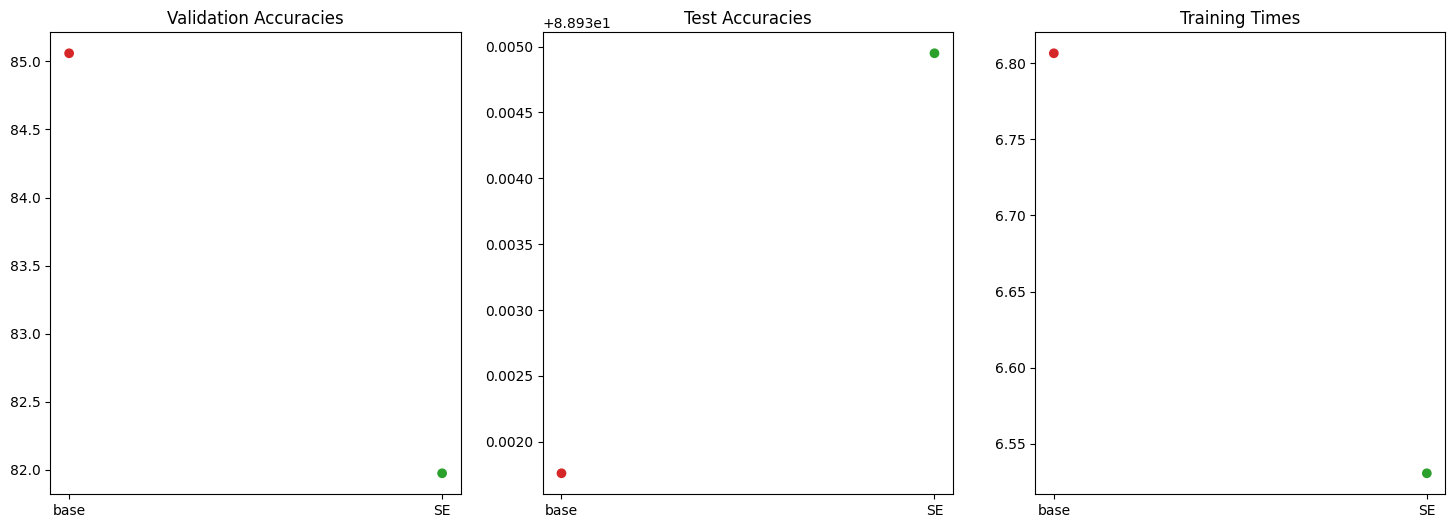

In [15]:
plt.figure(figsize=(18, 6))
plt.subplot(131)
plt.title('Validation Accuracies')
plt.scatter(names, eval_acc, color=colours)
plt.subplot(132)
plt.title('Test Accuracies')
plt.scatter(names, test_acc, color=colours)
plt.subplot(133)
plt.title('Training Times')
plt.scatter(names, time_taken, color=colours)
plt.show()

In [16]:
data = {'Names': names, 'Eval_Acc': eval_acc, 'Test_Acc': test_acc, 'Time_Taken': time_taken}

df = pd.DataFrame(data)
df

,Names,Eval_Acc,Test_Acc,Time_Taken
0,base,85.059294,88.931760,6.806523
1,SE,81.975480,88.934949,6.530632
